<a href="https://colab.research.google.com/github/sarathsreedharan/CS345/blob/master/spring24/notebooks/module07_03_neural_networks_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Ben Sattelberg and Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt

# Neural Networks

### Preface:  enabling GPUs on google colab

Until now we ran our neural networks on a CPU.  If you are running this notebook on google colab, you are in luck - google colab will allow you to run your code on a GPU.  Enabling a GPU is very simple:  All you need to do is navigate to Edit→Notebook Settings and select GPU from the Hardware Accelerator drop-down menu (also available from the Runtime menu).
This [colab notebook](https://colab.research.google.com/notebooks/gpu.ipynb) has instructions for verifying that you are using a GPU and see the resulting speedup.


## The MNIST dataset

In the previous notebooks we used Keras to solve toy problems and built some understanding of how the networks are solving those problems.  In this notebook, we'll look at the real (but still relatively easy) problem of handwritten digit recognition.  We will be using the MNIST (modified National Institute of Standards and Technology) database which has images taken from a NIST database of handwritten digits and modified by Yann Lecun, Corinna Cortes, and Christopher J.C. Burges to be more easily used in machine learning.

While no longer useful for demonstrating state-of-the-art advancments in machine learning, as a dataset, it will live on for a long time as both a teaching tools (see this lecture) and also some degree as a testbed for ideas aimed at better explaining the behavior of machine learning algorithms.  There is a good [Wikipedia article](https://en.wikipedia.org/wiki/MNIST_database) describing the dataset, which has been used in thousands of machine learning publications.

The first thing we need to do is to load the dataset.  Fortunately, Keras does this work for us:

In [3]:
# This will download an 11.5 MB file to ~/.keras/datasets/
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Let's get some information about the dataset:

In [4]:
print(X_train.shape, y_train.shape)
print(min(y_train), max(y_train))

(60000, 28, 28) (60000,)
0 9


This tells that we have 60,000 input images, each of which is 28x28 pixels.  The labels are, unsuprisingly for a database of digits, the numbers 0 through 9, corresponding to which digit the image represents.  Now let's look at the test set:

In [5]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


Here we have 10,000 samples with the same format as the training set.

Let's look at one of the images:

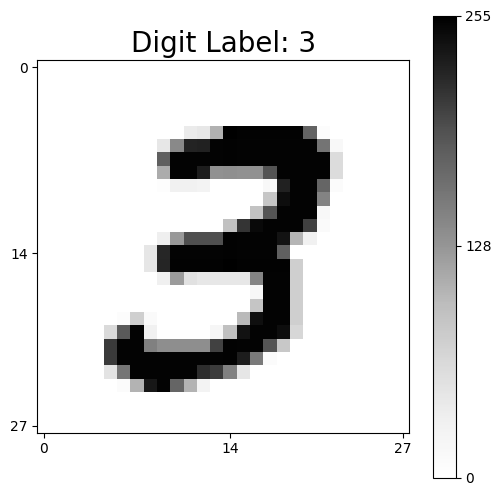

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
pick = 7
im = ax.imshow(X_train[pick, :, :], cmap='Greys')
ax.set_title("Digit Label: " + str(y_train[pick]),fontsize=20)
cbar = fig.colorbar(im)
cbar.set_ticks([0, 128, 255])
ax.set_xticks([0, 14, 27])
ax.set_yticks([0, 14, 27]);

Here we can see that the image is a grayscale 28x28 image with pixel values between 0 and 255.  We can also look at a few other images in the dataset:

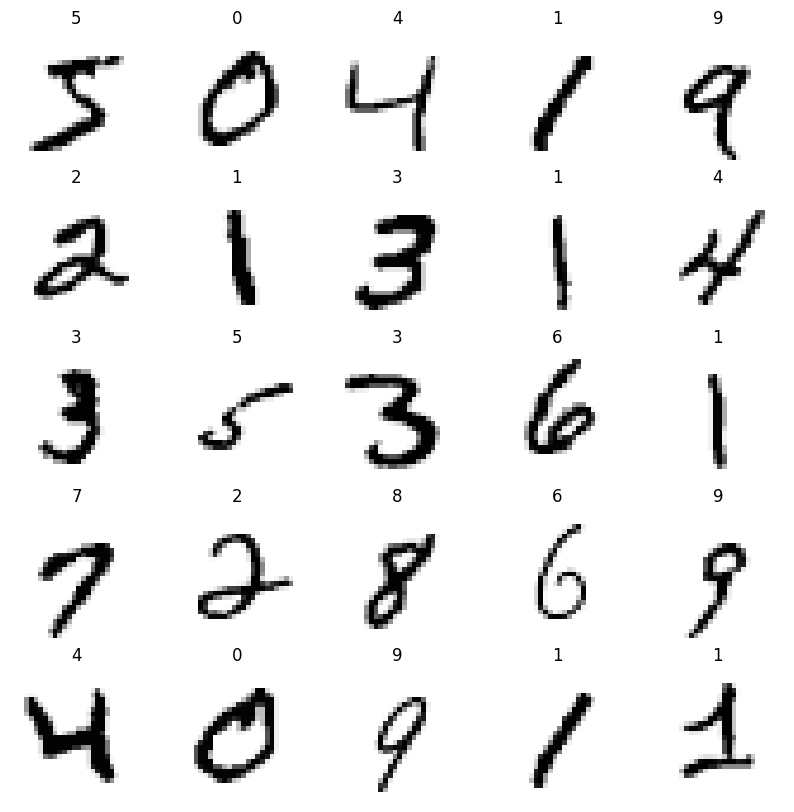

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))

for i in range(5):
    for j in range(5):
        axes[i,j].imshow(X_train[i*5 + j, :, :].reshape(28,28), cmap='Greys')
        axes[i,j].set_title(y_train[i*5+j])
        axes[i,j].axis('off')

There are a few things we want to do to the input data before we use it.  The first is to convert it to 32 bit floats:

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

We also want to change the range of the data from integers between 0 and 255 to numbers between 0 and 1 to help with training:

In [9]:
X_train /= 255
X_test /= 255

The last step, which is less obvious, is to reshape the actual data to have an extra dimension:

In [10]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

This dimension corresponds to the number of "channels" in the image.  This data is grayscale, but color images are typically stored in RGB (red, green, blue) format, where there the three channels describe the amount of red, green, and blue at each pixel.  Keras is designed to handle images as a native data format without needing to "flatten" the images into vectors as a preprocessing step.

We will also convert the `y_train` and `y_test` to a one-hot encoding:

In [11]:
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

We have reviewed one hot encoding several times, but just to keep in clear in everyone's mind, here we print out the original training signal (y vector) and the one hot encoding equivalent.

In [12]:
bnd=10
for i in range(bnd) :
    foo = [round(x) for x in y_test_one_hot[i]]
    print(f'sample {i}: {y_test[i]}, {foo}')

sample 0: 7, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
sample 1: 2, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
sample 2: 1, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
sample 3: 0, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sample 4: 4, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
sample 5: 1, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
sample 6: 4, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
sample 7: 9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
sample 8: 5, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
sample 9: 9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


### Baseline model:  no hidden layers

The first experiment we will do with this dataset is to test a simple linear model to get a baseline for how good we can expect our models to be.  We will use Keras for this, and simply not have any hidden layers in our network.

In addition to the accuracy on the training set, we want to keep track of the accuracy on the testing set.  One way to do this with Keras is with a callback function that keeps track of the accuracy on the testing set as we progress through it.  It isn't necessary to understand the code here, but it is good to be aware of the goal of this structure.

In [16]:
# Structure based on https://github.com/keras-team/keras/issues/2548
class EvaluateCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        if 'test loss' not in logs:
            logs['test loss'] = 0
            logs['test acc'] = 0
        logs['test loss'] += loss
        logs['test acc'] += acc
        print('\nTesting loss: {}, acc: {}'.format(round(loss, 4), round(acc, 4)))


We can now train our model.  One layer to notice is the ```Flatten()``` layer.  This layer converts the data from a 28x28x1 dimensional image to a 784=28\*28\*1 dimensional vector.

Also note the activation argument 'softmax' in the output layer. Recall from our previous notebook that there are two things notable about using softmax:

- The sum of the activiations, in our case ten output units, after softmax, will be forced to equal 1.0
- Most of the 'mass' will naturally be shifted to the unit with the largest input excitation.

In [17]:
linear_model = keras.Sequential()
linear_model.add(keras.layers.Flatten())
linear_model.add(keras.layers.Dense(10, activation='softmax'))
loss_fn = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

linear_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
linear_history = linear_model.fit(X_train, y_train_one_hot,
                                  batch_size=100, epochs=20,
                                  verbose=1, callbacks=[EvaluateCallback((X_test, y_test_one_hot))])

Epoch 1/20
589/600 [============================>.] - ETA: 0s - loss: 0.6292 - accuracy: 0.8429
Testing loss: 0.367, acc: 0.9057
600/600 [==============================] - 3s 4ms/step - loss: 0.6242 - accuracy: 0.8441 - test loss: 0.3670 - test acc: 0.9057
Epoch 2/20
579/600 [===========================>..] - ETA: 0s - loss: 0.3482 - accuracy: 0.9054
Testing loss: 0.3109, acc: 0.9136
600/600 [==============================] - 2s 3ms/step - loss: 0.3473 - accuracy: 0.9057 - test loss: 0.3109 - test acc: 0.9136
Epoch 3/20
583/600 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.9145
Testing loss: 0.2913, acc: 0.9186
600/600 [==============================] - 2s 3ms/step - loss: 0.3097 - accuracy: 0.9146 - test loss: 0.2913 - test acc: 0.9186
Epoch 4/20
578/600 [===========================>..] - ETA: 0s - loss: 0.2931 - accuracy: 0.9185
Testing loss: 0.284, acc: 0.9217
600/600 [==============================] - 2s 3ms/step - loss: 0.2923 - accuracy: 0.9187 - test lo

In [ ]:
print('Final loss: {}, test accuracy: {}'.format(*map(lambda x: round(x, 4), linear_model.evaluate(X_test, y_test_one_hot, verbose=0))))

Final loss: 0.2634, test accuracy: 0.9284


We can look at the summary of this model - the main thing to note here is the number of parameters:

In [ ]:
linear_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 784)               0         
                                                                 
 dense_29 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can also look at the accuracy over the epochs of the network:

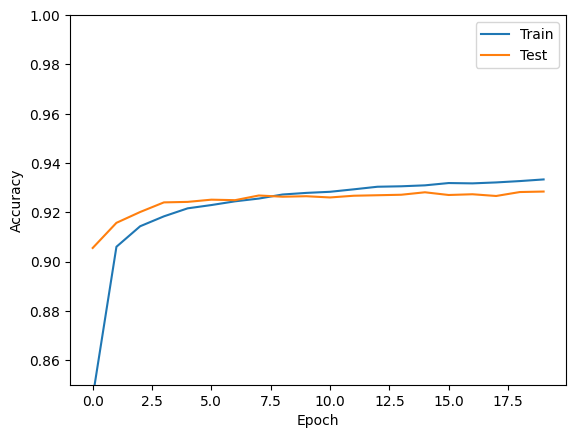

In [ ]:
plt.plot(linear_history.history['accuracy'], label='Train')
plt.plot(linear_history.history['test acc'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.85, 1]);

We can see that even a simple linear classifier gets about 92% accuracy.  MNIST is commonly used as a tutorial dataset, and one of the reasons for that is that basically anything will be successful on it.  The dataset is also solved - methods exist that do better than human accuracy and will reach around 99.9% accuracy (i.e 10 samples out of the 10,000 misclassified).

## An MNIST network

Now let's train a more interesting neural network on this problem.  We'll start with a single hidden layer with 128 nodes:

In [18]:
network = keras.Sequential()
network.add(keras.layers.Flatten())
network.add(keras.layers.Dense(100, activation='relu'))
network.add(keras.layers.Dense(10, activation='softmax'))
loss_fn = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

network.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
history = network.fit(X_train, y_train_one_hot, batch_size=100,
                      epochs=20, verbose=1,
                      callbacks=[EvaluateCallback((X_test, keras.utils.to_categorical(y_test, 10)))])

Epoch 1/20
591/600 [============================>.] - ETA: 0s - loss: 0.3594 - accuracy: 0.9033
Testing loss: 0.1998, acc: 0.9407
600/600 [==============================] - 4s 6ms/step - loss: 0.3574 - accuracy: 0.9039 - test loss: 0.1998 - test acc: 0.9407
Epoch 2/20
590/600 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9518
Testing loss: 0.1487, acc: 0.9563
600/600 [==============================] - 2s 4ms/step - loss: 0.1700 - accuracy: 0.9519 - test loss: 0.1487 - test acc: 0.9563
Epoch 3/20
599/600 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9638
Testing loss: 0.1184, acc: 0.9651
600/600 [==============================] - 3s 5ms/step - loss: 0.1237 - accuracy: 0.9639 - test loss: 0.1184 - test acc: 0.9651
Epoch 4/20
584/600 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9717
Testing loss: 0.1044, acc: 0.969
600/600 [==============================] - 2s 4ms/step - loss: 0.0976 - accuracy: 0.9717 - test l

In [ ]:
print('Final loss: {}, test accuracy: {}'.format(*map(lambda x: round(x, 4), network.evaluate(X_test, y_test_one_hot, verbose=0))))

Final loss: 0.0963, test accuracy: 0.9754


The total number of parameters for this network is more than an order of magnitude higher than the linear model.  However, it does improve on the linear model's accuracy from 92% to about 97.5%.

In [ ]:
network.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 784)               0         
                                                                 
 dense_30 (Dense)            (None, 100)               78500     
                                                                 
 dense_31 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The network also reaches nearly 100% accuracy on the training set, and continues improving on the training set after it plateaus in accuracy on the test set.  This is a sign that the network has found a solution to and that further training can potentially *reduce* the accuracy through overfitting.

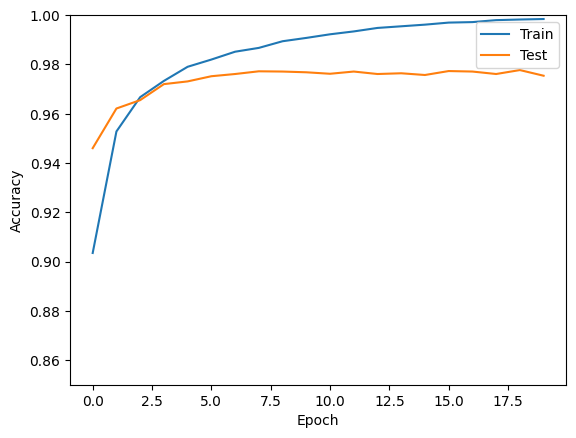

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['test acc'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.85, 1]);

Since there's the potential to overfit, and a large number of parameters, simply increasing the depth or the width of this network could potentially lead to issues.  Instead of going that route, we will use a different kind of layer in our next notebook that works well for images and introduce convolutional networks, which have become the standard architecture for image data.

For reference, and to convince ourselves that we obtained good accuracy with our neural network let's try random forests:

In [ ]:
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_flat, y_train);

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_test_flat)
accuracy_score(y_pred, y_test)

0.9719

### Comments

There are major issues in using feed-forward neural networks for image classification:

* Fully connected networks can have very large numbers of parameters with increasing image sizes.  Consider for example images of size 228x228x3, which is standard in this field.  Using the network architecture we have here would result in 228\*228\*3\*100 parameters from the input to the hidden layer - about 15,000,000.  This network would also not be successful - we would need to significantly increase the width and depth, compounding the issue.  It is likely that billions of parameters would be necessary to achieve good accuracy.
* If we take an image that represents the number seven, and shift the seven over a few pixels, we would expect it to still be classified as a seven.  However, fully connected networks are not able to represent this invariance.

Some of these concerns apply to other standard machine learning approaches as well.
Convolutional networks which are introduced next, address these shortcomings, and have led to major improvements in accuracy in image classification tasks.  Their success has led to a renaissance of the field of neural networks.